# **🎬 Movie Recommendation Systems: A Comparative Study**

## **I. Introduction**

### **i. Context**

Birds of a feather flock together—and so do people with similar tastes in movies.

Word-of-mouth has long been one of the most trusted sources of movie recommendations. Phrases like “my friends said it was good” often carry more weight than professional reviews, largely because shared preferences built over time create mutual trust. This intuition is reflected in my own experience. After spending three hours watching and discussing Legends of the Fall with a close friend, he was surprised by how closely our movie preferences aligned. Since then, we have relied heavily on each other’s recommendations, which have consistently matched our tastes.

While such human-based recommendations can be remarkably accurate, they do not scale. Online streaming platforms face a fundamentally different challenge: users simply do not have enough friends to explore the vast and ever-growing catalogs available today. Platforms like Netflix operate at a massive scale, serving millions of users and hosting tens of thousands of titles. In this context, automated recommendation systems become essential.

By leveraging users’ historical interactions with movies, a recommendation system can identify patterns in preferences and suggest relevant content. This not only enhances user satisfaction but also increases user engagement and, ultimately, platform revenue.

Although this project focuses on movie recommendations, the techniques explored here are broadly applicable. The same principles can be extended to recommend any type of item—such as music, products, or articles—where user preference data is available.

### **ii. Objective**

In this case study, we build and compare several recommendation system approaches:

- **Knowledge- / Rank-based recommendation systems**
- **Similarity-based collaborative filtering**
- **Matrix factorization–based collaborative filtering**

To demonstrate these techniques, we use a **movie ratings dataset**, which captures users’ historical interactions with items and serves as the foundation for modeling user preferences.

### **iii. Dataset**

The **ratings** dataset consists of the following attributes:

- **userId**: A unique identifier for each user  
- **movieId**: A unique identifier for each movie  
- **rating**: The rating assigned by a user to a movie  
- **timestamp**: The time at which the rating was recorded

### **iv. Libraries**

In [1]:
# I. ----- Introduction -----
# This chapter does not have Python code.

# II. ----- Data Overview -----
import pandas as pd
import matplotlib.pyplot as plt

# III. ----- Modelling -----
import sys
from surprise import SVD, Dataset, Reader
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
from collections import defaultdict
import numpy as np

## **II. Data Overview**

### **i. Data Retrieval**

In [2]:
# Import dataset
rating = pd.read_csv('ratings.csv')

In [3]:
# Dataframe info
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


🔬 **Observations**

- The dataset contains **100,836 rating records** with **4 features**, indicating a moderately sized dataset suitable for collaborative filtering experiments.
- All columns have **no missing values**, eliminating the need for imputation during preprocessing.
- The dataset includes **three integer-type features** (`userId`, `movieId`, `timestamp`) and **one continuous feature** (`rating`), which is the primary target variable for modeling.
- The `rating` column is stored as a floating-point value, making it directly usable for regression-based recommendation models.
- The total memory usage is approximately **3.1 MB**, allowing efficient in-memory processing without performance concerns.

In [4]:
# Drop columns
rating = rating.drop(['timestamp'], axis = 1)

In [5]:
# First five rows
rating.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### **ii. Explorative Data Analysis**

#### **1. Total Number of Unique Users**

In [6]:
# Finding number of unique users by using nunique method
rating['userId'].nunique()

610

#### **2. Total Number of Unique Movies**

In [7]:
# Finding the number of unique movies
rating['movieId'].nunique()

9724

🔬 **Observations**

- There are **9,724 unique movies** in the dataset.
- As per the number of unique users and movies, there is a **possibility of 610 * 9724 = 59,31,640 ratings** in the dataset. But **we only have 100,836 ratings**, i.e., not every user has rated every movie in the dataset, which is quite understandable. This creates the possibility of building a recommendation system to recommend movies to the users which they have not interacted with.

#### **3. Is there any movie that has been interacted with more than once by the same user?**

In [8]:
# Find the frequency of movies rated by each user
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      1             1
       3             1
       6             1
       47            1
       50            1
...                ...
610    166534        1
       168248        1
       168250        1
       168252        1
       170875        1

[100836 rows x 1 columns]

In [9]:
# Find the sum of ratings count by user-movie pair
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100836

🔬 **Observations**

- The **sum is equal to the total number of observations**, which implies that **there is only one interaction between a pair of a movie and a user**.

#### **4. Which one is the most interacted movie in the dataset?**

In [10]:
# Count the number of people who have watched a certain movie
rating['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
152085      1
164367      1
98799       1
4573        1
6141        1
Name: movieId, Length: 9724, dtype: int64

🔬 **Observations**

- The **movie with movieId 356 has been interacted by most users** which is **329** times.
- But still, there is a possibility of 610-329 = 281 more interactions as we have 610 unique users in our dataset. For those 281 remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.

Also, out of these 329 interactions, we need to consider the distribution of ratings as well to check whether this movie is the most liked or most disliked movie.

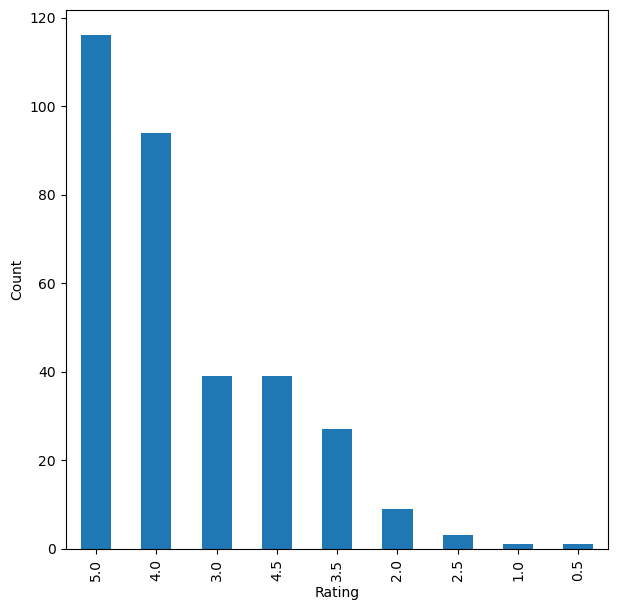

In [11]:
plt.figure(figsize = (7, 7))
rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

🔬 **Observations**

- We can see that **this movie has been liked by the majority of users**, as the count of ratings 5 and 4 is higher than the count of lower ratings.
- There can be movies with very high interactions but the count of ratings 1 and 2 may be much higher than the count for ratings 4 or 5 which would imply that the movie is disliked by the majority of the users.

#### **5. Which user interacted the most with any movie in the dataset?**

In [12]:
# Count the number of movies each user has watched
rating['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
320      20
569      20
442      20
257      20
406      20
Name: userId, Length: 610, dtype: int64

🔬 **Observations**

- The user with **userId: 414** has interacted with the most number of movies, i.e., **2,698** times.
- But still, there is a possibility of 9724 - 2698 = 7026 more interactions as we have 9724 unique movies in our dataset. For those **7026** remaining movies, we can build a recommendation system to predict which movies are most likely to be watched by this user.

#### **6. What is the distribution of the user-movie interactions in this dataset?**

In [13]:
# Find user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

## **III. Modelling**

### **i. Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the **most popular items**. This kind of recommendation system is useful when we have **cold start** problem. Cold start refers to the issue when we get a new user into the system and the machine is **not** able to recommend movies to him, as the user did not have any historical interactions available in the dataset. In those cases, we can use a rank-based recommendation system to recommend movies to the new user.

#### **1. Average Ratings**

In [14]:
# Calculate average ratings for each movie
average_rating = rating.groupby('movieId').mean()['rating']
# Calculate the count of ratings for each movie
count_rating = rating.groupby('movieId').count()['rating']
# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [15]:
# First 5 records of the final_rating dataset
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


#### **2. Find the Top n Movies**

**Function Preparation**

In [16]:
# It gives top n movies among those being watched for more than min_interactions
def top_n_movies(data, n, min_interaction = 100):

    # Finding movies with interactions greater than the minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to the average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

**Recommend the Top 5 Movies with 50 Minimum Interactions Based on Popularity**

In [17]:
list(top_n_movies(final_rating, 5, 50))

[318, 858, 2959, 1276, 750]

**Recommend the Top 5 Movies with 100 Minimum Interactions Based on Popularity**

In [18]:
list(top_n_movies(final_rating, 5, 100))

[318, 858, 2959, 1221, 48516]

**Recommend the Top 5 Movies with 200 Minimum Interactions Based on Popularity**

In [19]:
list(top_n_movies(final_rating, 5, 200))

[318, 2959, 50, 260, 527]

### **ii. Model 2: Collaborative Filtering Based Recommendation System**

In a **collaborative filtering recommendation system**, we do **not require any information about the user or the item itself**. Instead, the system relies solely on **user–item interaction data** to generate recommendations. Examples of such interactions include:

1. **Ratings** provided by users (e.g., book ratings on Goodreads, movie ratings on IMDb)  
2. **Likes** given by users (e.g., likes on Facebook posts, YouTube videos)  
3. **Usage or purchases** of products (e.g., buying items on e-commerce platforms)  
4. **Reading behavior** (e.g., articles read on blogs or news sites

Types of Collaborative Filtering are
- Similarity/Neighborhood-based
 - User-User similarity-based  
 - Item-Item similarity-based
- Model-based

#### **1. User-User Similarity/Neighborhood-Based Collaborative Filtering Recommendation Systems**

##### **1.1 Preparation**

In [20]:
# Test import success
print(sys.version)
print("Surprise works 🎉")

3.9.23 (main, Jun  5 2025, 08:23:30) 
[Clang 14.0.6 ]
Surprise works 🎉


**Function Preparation**

Prepare a function that builds evaluation metrics.

In [21]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """
    Computes Precision@K, Recall@K, and F1-score for a recommendation model
    using explicit rating predictions.

    The function evaluates the model by comparing predicted ratings with
    true ratings on the test set. Items with ratings greater than or equal
    to the specified threshold are considered relevant.

    To compute precision and recall, a threshold of 3.5 and k value of 10 
    is taken for the recommended and relevant ratings.
    
    Parameters
    ----------
    model : surprise.prediction_algorithms.knns.KNNBasic
        The recommendation model.
    k : int, optional
        The number of top-ranked items. The default is 10.
    threshold : float, optional
        It defines what counts as "relevant". The default is 3.5.

    Returns
    -------
    None.
    
    """

    # Map the predictions to each user
    user_est_true = defaultdict(list)
    # Predictions on the test data
    predictions = model.test(testset)
    # Add estimation and true r to the predictions
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Initialize prediction and recall
    precisions = dict()
    recalls = dict()
    # Iterate each user and his ratings
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    # RMSE score
    accuracy.rmse(predictions)
    # Print overall precision
    print('Precision: ', precision)
    # Print overall precision
    print('Recall: ', recall)
    # Print F1 score
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3))

**DataFrame Conversion**

Convert the `rating` dataset (**DataFrame**), into a different format, `surprise.dataset.DatasetAutoFolds`. This is required by the surprise library.

In [22]:
# Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Load the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
# Split the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

##### **1.2 Model Evaluation**

- Now, let's build the first baseline **similarity-based** recommendation system using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**. It is used to find the **desired similar items among a given set of items**.

**Baseline Similarity-based Recommendation System (Using the Cosine Similarity)**

In [23]:
# Declare the similarity options
sim_options = {'name': 'cosine', 'user_based': True}
# KNN algorithm to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)
# Train the algorithm on the train set, and predict ratings for the test set
sim_user_user.fit(trainset)
# Compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 0.9823
Precision:  0.757
Recall:  0.542
F_1 score:  0.632


🔬 **Observations**

- The model achieves an **RMSE of 0.9823**, indicating a reasonable level of accuracy in predicting user ratings, though there remains room for improvement in reducing prediction error.
- A **Precision@K of 0.757** suggests that a large proportion of the recommended items are relevant, indicating strong recommendation quality among the top-ranked items.
- The **Recall@K of 0.542** indicates that slightly over half of the relevant items are successfully captured within the top-`k` recommendations, reflecting a moderate trade-off between coverage and accuracy.
- The resulting **F1-score of 0.632** demonstrates a balanced performance between precision and recall, suggesting that the model provides relevant recommendations while maintaining acceptable coverage.

**Prediction with the Sample User (`userId = 4`, `movieId = 10`)**

In [24]:
# Predict
sim_user_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.41   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.4133289774831344, details={'actual_k': 40, 'was_impossible': False})

🔬 **Observations**

- For user **4** and movie **10**, the actual rating is **4.0**, while the model predicts a rating of approximately **3.41**.
- The prediction slightly **underestimates the user’s true preference**, indicating a moderate prediction error for this user–item pair.
- Since `was_impossible` is **False**, the model was able to generate the prediction using sufficient neighborhood information.
- The value `actual_k = 40` indicates that the prediction was based on **40 nearest neighbors**, suggesting that the estimate is supported by a reasonably sized local user neighborhood.

**The List of Users Who Have not Seen the Product with Movie id "3"**.

In [25]:
def n_users_not_interacted_with(n, data, movieId):
    """
    Returns a list of users who have not interacted with a given movie.

    This function identifies users who have not rated or interacted with
    the specified movie and returns up to `n` such users. It is useful for
    tasks such as candidate user selection or evaluating potential
    recommendations for unseen items.

    Parameters
    ----------
    n : int
        The number of users to return.
    data : pandas.core.frame.DataFrame
        The ratings dataset containing at least the columns `userId` and `movieId`.
    movieId : int
        The unique identifier of the movie.

    Returns
    -------
    list
        A list of user IDs (first n) who have not interacted with the specified movie.

    """
    # Identify users who have already interacted with (rated) the given movie
    users_interacted_with_product = set(data[data['movieId'] == movieId]['userId'])
    # Get the set of all unique users in the dataset
    all_users = set(data['userId'])
    # Return the first n users who have NOT interacted with the given movie
    return list(all_users.difference(users_interacted_with_product))[:n]

n_users_not_interacted_with(5, rating, 3)

[2, 3, 4, 5, 7]

🔬 **Observations**

- As the above list contains user id 4, we can say that **user with user id 4 has not seen the movie with movieId 3**.

Below, we are **predicting the rating for the same `userId = 4` but for a movie with which this user has not interacted yet, i.e., `movieId = 3`**.

In [26]:
# Predict rating for a sample user with a non interacted movie
sim_user_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.260929007645626, details={'actual_k': 40, 'was_impossible': False})

🔬 **Observations**

- For user **4** and movie **3**, the model predicts a rating of approximately **3.26**.
- The true rating (`r_ui`) is **missing**, indicating that the user has not previously interacted with this movie.
- Since `was_impossible` is **False**, the model was able to generate a prediction using available neighborhood information rather than default values.
- The value `actual_k = 40` shows that the prediction is based on **40 nearest neighbors**, suggesting that the estimate is supported by sufficient collaborative information.
- This prediction represents a **candidate recommendation**, as it estimates the user’s potential preference for an unseen item.

##### **1.3 Hyperparameter Tuning**

**Parameter Overview**

- **k** (int): The (max) number of neighbors to take into account for aggregation. The default value of k is 40.
- **min_k** (int): The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. The default value is 1.
- **sim_options** (dict): A dictionary of options for the similarity measure. And there are four similarity measures available in surprise:
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

**Note:** GridSearchCV does not accept the metrics recall@k, precision@k, or F1 Score@k. As a result, we'll tune the model using RMSE.

**Grid Search**

In [27]:
# Set up parameter grid to tune the hyperparameters
param_grid = {'k': [30, 40, 50], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Perform 3-Fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on data
gs.fit(data)
# Print the best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9487213657353748
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


**Final Model**

In [28]:
# Use the optimal similarity measure for user-user collaborative filtering
sim_options = {'name': 'msd', 'user_based': True}
# Create an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 3, random_state = 1, verbose = False)
# Train the algorithm on the train set
sim_user_user_optimized.fit(trainset)
# Compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9467
Precision:  0.762
Recall:  0.554
F_1 score:  0.642


🔬 **Observations**

- The model achieves an **RMSE of 0.9467**, indicating improved accuracy in predicting user ratings compared to previous results.
- A **Precision@K of 0.762** suggests that the majority of recommended items are relevant, reflecting strong performance among top-ranked recommendations.
- The **Recall@K of 0.554** shows a modest improvement in the model’s ability to capture relevant items within the top-`k` recommendations.
- The resulting **F1-score of 0.642** demonstrates a balanced trade-off between precision and recall, indicating overall improvement in recommendation quality.

**User Prediction (`userId = 4`, `movieId = 10`)**

In [29]:
sim_user_user_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.50   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.497691535784751, details={'actual_k': 30, 'was_impossible': False})

🔬 **Observations**

- If we compare the predicted rating with the actual raring, we can say that the **predicted rating by the tuned model is closer to the actual rating in comparison to the prediction by the baseline model**.

**User Prediction (`userId = 4`, `movieId = 3`)**

Predict the rating for the same **`userId = 4`** but for a movie with which this user has **not interacted before**, i.e., `movieId = 3`, by using the **optimized model** as shown below.

In [30]:
sim_user_user_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.45   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4530529132024763, details={'actual_k': 30, 'was_impossible': False})

**Similar Users (Nearest Neighbors)**

Find similar users to a given user (**nearest neighbors**) based on this KNNBasic algorithm. Below, we look for **the 5 most similar users to `userId = 4`** based on the **`msd` distance metric**.

In [31]:
sim_user_user_optimized.get_neighbors(4, k = 5)

[89, 90, 91, 181, 230]

##### **1.4 Implement Based on Optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: The **rating** dataset.
- user_id: The user id **for which we want the recommendations**.
- top_n: The **number of movies we want to recommend**.
- algo: The algorithm we want to use **for predicting the ratings**.
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm.

In [32]:
def get_recommendations(data, user_id, top_n, algo):
    """
    Generates top-N movie recommendations for a given user using a trained 
    recommendation algorithm.

    This function identifies movies that the specified user has not yet 
    interacted with, predicts the user's ratings for these unseen movies 
    using the provided recommendation model, and returns the top-N movies 
    with the highest predicted ratings.

    Parameters
    ----------
    data : pandas.core.frame.DataFrame
        The ratings dataset containing at least the columns 'userId', 
        'movieId', and 'rating'.
    user_id : int
        The ID of the user for whom recommendations are to be generated.
    top_n : int
        The number of top recommendations to return.
    algo : surprise.prediction_algorithms.knns.KNNBasic
        A trained recommendation model from the Surprise library used to 
        predict ratings for unseen items.

    Returns
    -------
    list of tuples
        A list of `(movieId, predicted_rating)` tuples, sorted by predicted 
        rating in descending order, containing the top-N recommended movies 
        for the specified user.
    """

    # Initialize a list to store (movieId, predicted_rating) pairs
    recommendations = []
    # Create a user–item interaction matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    # Identify movies that the given user has NOT yet interacted with (i.e., missing ratings for this user)
    non_interacted_movies = (
        user_item_interactions_matrix
        .loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()]
        .index
        .tolist()
    )
    # Loop through each unseen movie for the user
    for item_id in non_interacted_movies:
        # Predict the user's rating for the unseen movie using the trained model
        est = algo.predict(user_id, item_id).est
        # Store the movie ID along with its predicted rating
        recommendations.append((item_id, est))
    # Sort all candidate movies by predicted rating in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]

##### **1.5 Predict Top 5 Movies (UserId = 4)**

In [33]:
# Making top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_user_user_optimized)

In [34]:
# Building the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,3404,5.000000
1,7121,5.000000
2,6460,4.844207
3,115122,4.813285
4,1178,4.808807


##### **1.6 Correct the Ratings and Ranking**

In [35]:
def ranking_movies(recommendations, final_rating):
    """
    Ranks recommended movies by combining predicted ratings with item popularity.

    This function adjusts the predicted ratings of recommended movies by applying
    a popularity-based correction derived from the number of ratings each movie
    has received. The correction penalizes movies with low rating counts, helping
    reduce the risk of over-ranking items with unreliable predictions.

    Parameters
    ----------
    recommendations : list
        A list of `(movieId, predicted_rating)` tuples produced by a recommendation model.
    final_rating : pandas.core.frame.DataFrame
        A DataFrame indexed by `movieId` containing at least the column `rating_count`, 
        which represents the number of ratings received by each movie.

    Returns
    -------
    ranked_movies : pandas.core.frame.DataFrame
        A DataFrame containing the recommended movies ranked by corrected ratings.
        The output includes `movieId`, `rating_count`, `predicted_ratings`, and
        `corrected_ratings`, sorted in descending order of corrected ratings.

    """

    # Sort the movies based on ratings count
    ranked_movies = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()
    # Merge with the recommended movies to get predicted ratings
    ranked_movies = ranked_movies.merge(pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings']), on = 'movieId', how = 'inner')
    # Rank the movies based on corrected ratings
    ranked_movies['corrected_ratings'] = ranked_movies['predicted_ratings'] - 1 / np.sqrt(ranked_movies['rating_count'])
    # Sort the movies based on corrected ratings
    ranked_movies = ranked_movies.sort_values('corrected_ratings', ascending = False)

    return ranked_movies

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some movies with ratings of 5 and **we can't have a rating more than 5 for a movie**.

In [36]:
# Applying the ranking movies function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
1,3404,6,5.000000,4.591752
0,1178,12,4.808807,4.520132
3,7121,4,5.000000,4.500000
2,6460,5,4.844207,4.396993
4,115122,3,4.813285,4.235934


#### **2. Item-Item Similarity-Based Collaborative Filtering Recommendation Systems**

In [37]:
# Declare the similarity options
sim_options = {'name': 'cosine', 'user_based': False}
# The KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
# Train the algorithm on the train set, and predict ratings for the testset
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9800
Precision:  0.609
Recall:  0.464
F_1 score:  0.527


##### **2.1 GridSearchCV**

In [38]:
# Predict rating for a sample user with an interacted movie
sim_item_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6257369831511945, details={'actual_k': 40, 'was_impossible': False})

🔬 **Observations**
- The above output shows that **the actual rating for this user-item pair is 4, and the predicted rating is close to that**.

##### **2.2 Rating Prediction (`userId = 4`, `movieId = 3`)**.

We are **the same `userId = 4`** but for a movie with which this user has **not** interacted yet, i.e., `movieId = 3`.

In [39]:
# Predict rating for a sample user with a non interacted movie
sim_item_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.67   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6748659322681623, details={'actual_k': 40, 'was_impossible': False})

##### **2.3 Hyperparameters Tuning (`KNNBasic`)**

In [40]:
# Set up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Perform 3-Fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on the data
gs.fit(data)
# Print the best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9171967418916912
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Now, let's build the model using the **optimal values of the hyperparameters**, which we received using the grid search cross-validation.

In [41]:
# Use the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}
# Create an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)
# Train the algorithm on the train set
sim_item_item_optimized.fit(trainset)
# Compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9160
Precision:  0.678
Recall:  0.499
F_1 score:  0.575


🔬 **Observations**

- We can observe that after tuning hyperparameters, **F_1 score of the model is better than the baseline model**. Along with this, **the RMSE of the model has gone down in comparison to the model with default hyperparameters**. Hence, we can say that the model performance has improved after hyperparameter tuning.

##### **2.4 Prediction (`userId = 4`, `movieId = 10` or `movieId = 3`)**

In [42]:
sim_item_item_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.26   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.2569148418342952, details={'actual_k': 30, 'was_impossible': False})

🔬 **Observations**

- For **user 4** and **movie 10**, the actual rating is **4.0**, while the model predicts a rating of approximately **3.26**.
- The prediction slightly **underestimates the user’s true preference**, indicating a moderate prediction error for this user–item pair.
- The value `actual_k = 30` indicates that the prediction is based on **30 nearest neighbors**, suggesting that a sufficient amount of collaborative information was available.
- Since `was_impossible` is **False**, the model successfully generated the prediction using neighborhood-based information rather than default or fallback values.
- This example illustrates a common behavior of collaborative filtering models, which tend to **regress predictions toward the mean**, especially when user preferences are not strongly expressed.

In [43]:
sim_item_item_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.574650247164053, details={'actual_k': 30, 'was_impossible': False})

🔬 **Observations**

- For **user 4** and **movie 3**, the model predicts a rating of approximately **3.57**.
- The absence of an actual rating (`r_ui = None`) indicates that the user has **not previously interacted** with this movie, making this a true **recommendation scenario** rather than an evaluation case.
- The prediction is based on **30 nearest neighbors** (`actual_k = 30`), suggesting that sufficient collaborative information was available to support the estimate.
- Since `was_impossible` is **False**, the model successfully generated the prediction using neighborhood-based data rather than default assumptions.
- A predicted rating above the relevance threshold (e.g., 3.5) suggests that this movie is a **potentially strong candidate for recommendation** to the user.

##### **2.5 Implement the Model**

Find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below, we are finding the 5 most similar items to `ItemId = 3` based on the `msd` distance metric.

In [44]:
sim_item_item_optimized.get_neighbors(3, k = 5)

[26, 83, 248, 254, 343]

##### **2.6 Predict Top 5 Movies (`userId` = 4) Using the Similarity-Based Recommendation System**

In [45]:
# Mak top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_item_item_optimized)

In [46]:
# Build the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,5706,4.771028
1,176579,4.748016
2,25959,4.744049
3,2149,4.730439
4,56176,4.724374


In [47]:
# Apply the "ranking_movies" function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,2149,4,4.730439,4.230439
1,56176,3,4.724374,4.147023
2,5706,1,4.771028,3.771028
3,176579,1,4.748016,3.748016
4,25959,1,4.744049,3.744049


### **iii. Model 3: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### **1. Singular Value Decomposition (SVD)**

##### **1.1 Baseline Matrix Factorization Recommendation System**

In [48]:
# SVD with matrix factorization
svd = SVD(random_state = 1)
# Train the algorithm on the training dataset
svd.fit(trainset)
# Compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd)

RMSE: 0.8797
Precision:  0.738
Recall:  0.507
F_1 score:  0.601


🔬 **Observations**

- The model achieves an **RMSE of 0.8797**, indicating a relatively low prediction error and good overall accuracy in rating estimation.
- A **precision of 0.738** shows that a high proportion of the recommended items are relevant to users, reflecting strong recommendation quality.
- The **recall of 0.507** indicates that the model captures just over half of the relevant items, suggesting there is room to improve coverage.
- The resulting **F₁ score of 0.601** demonstrates a balanced trade-off between precision and recall, with a slight emphasis on recommendation accuracy.
- Overall, the model performs **reliably but conservatively**, favoring accurate recommendations while potentially missing some relevant items.

##### **1.2 Predictions**

In [49]:
# Prediction for userId 4 and movieId 10
svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.33   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.333359479354037, details={'was_impossible': False})

🔬 **Observations**

- For **user 4** and **item 10**, the actual rating is **4.0**, while the model predicts an estimated rating of **3.33**.
- The predicted rating is slightly lower than the true rating, indicating a **mild underestimation** by the model for this user–item pair.
- The prediction was **successfully computed** (`was_impossible: False`), meaning sufficient information was available to generate the estimate.
- This result suggests the model captures the user’s preference trend reasonably well, though it does not fully reflect the user’s higher affinity for this item.

In [50]:
# Prediction for userid 4 and movieId 3
svd.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 2.94   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=2.9386110726567756, details={'was_impossible': False})

🔬 **Observations**

- For **user 4** and **item 3**, there is **no actual rating available** (`r_ui = None`), indicating that the user has not previously interacted with this item.
- The model predicts an estimated rating of **2.94**, suggesting a **moderate to slightly below-average preference** for this item.
- The prediction was **successfully generated** (`was_impossible: False`), showing that the model had enough information from similar users/items to infer a rating.
- This estimate can be used to **rank and recommend** items for the user, even in the absence of historical interaction data.

#### **2. Hyperparameter Tunning**

There are three hyperparameters for tunning:
- **n_epochs**: The number of iterations of the SVD algorithm.
- **lr_all**: The learning rate for all the parameters.
- **reg_all**: The regularization term for all the parameters.

In [51]:
# Set the parameter space to do hyperparameter tuning
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Perform 3-Fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on the data
gs.fit(data)
# Print the best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.871862946998351
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [52]:
# Build the optimized SVD model using optimal hyperparameters search
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)
# Train the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.8752
Precision:  0.731
Recall:  0.511
F_1 score:  0.602


🔬 **Observations**
- There is no significant improvement even with hyperparameter tunning.

#### **3. Prediction**

Let's now predict the rating for the user with `userId = 4` and the movie with `movieId = 10` with the optimized model as shown below.

In [53]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 10
svd_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.39   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.3892642624049993, details={'was_impossible': False})

In [54]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 3 with unknown baseline rating
svd_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.20286300753659, details={'was_impossible': False})

#### **4. Recommendation**

In [55]:
# Getting top 5 recommendations for userId 4 using "svd_algo_optimized" algorithm
svd_recommendations = get_recommendations(rating, 4, 5, svd_optimized)

In [56]:
# Ranking movies based on above recommendations
ranking_movies(svd_recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,1178,12,4.446400,4.157725
1,177593,8,4.380428,4.026875
2,106642,7,4.379596,4.001631
3,3266,6,4.332485,3.924236
4,7121,4,4.342665,3.842665


## **IV. Conclusion**

In this case study, we implemented **four different recommendation system approaches**:

- **Rank-based recommendation** using average ratings  
- **User–User similarity-based collaborative filtering**  
- **Item–Item similarity-based collaborative filtering**  
- **Model-based collaborative filtering** using **matrix factorization**

The **Surprise** library was used to implement the **user–user**, **item–item**, and **model-based (matrix factorization)** collaborative filtering algorithms. For each of these models, **grid search with cross-validation** was applied to identify the optimal hyperparameters, and predictions were generated using the best-performing configurations.

To evaluate model performance, **Precision@K** and **Recall@K** were computed, and the **F₁-score** was derived from these metrics for each model. Among all approaches, the **user–user similarity-based collaborative filtering model** achieved the **highest F₁-score**, indicating the best overall performance.

Further improvements may be achieved through **additional hyperparameter tuning**. Moreover, combining multiple recommendation techniques could lead to the development of **hybrid recommendation systems**, potentially improving both accuracy and robustness.